https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection/code/data/data


In [55]:
import pandas as pd
import numpy as np
import torch
from torch import nn
import torchvision
from torch.utils.data import DataLoader,Dataset
from tqdm import tqdm
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torchvision.transforms import transforms
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.models as models

In [56]:
labels = []
images = []
base_dir = './brain_tumor_dataset/'
for i in os.listdir(base_dir):
    for x in os.listdir(f'./brain_tumor_dataset/{i}'):
        labels.append(i)
        images.append(base_dir+i+'/'+x)
        
df = pd.DataFrame(zip(images,labels),columns=('image_path','label'))


In [57]:
train_df = df.copy()
train_df.head(3)

,image_path,label
0,./brain_tumor_dataset/no/1 no.jpeg,no
1,./brain_tumor_dataset/no/10 no.jpg,no
2,./brain_tumor_dataset/no/11 no.jpg,no


In [58]:
x_train,x_temp,y_train,y_temp = train_test_split(train_df['image_path'],train_df['label'],test_size=.3,stratify=train_df['label'])
x_val,x_test,y_val,y_test = train_test_split(x_temp,y_temp,stratify=y_temp,test_size=.5)

In [59]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [60]:
label_encoder = LabelEncoder()

label_encoder.fit(train_df['label'])

LabelEncoder()

In [61]:
IMAGE_SIZE = 224
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(IMAGE_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN,IMAGENET_STD)
])

val_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN,IMAGENET_STD)
])

In [62]:
class CustomDataset(Dataset):
    def __init__(self,x,y,transforms=None):
        self.X = x
        self.Y = torch.tensor(label_encoder.transform(y).astype(int),dtype=torch.long)
        self.transforms = transforms
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self,index):
        image_path = self.X[index]
        label= self.Y[index]
        image = Image.open(image_path).convert('RGB')
        if self.transforms:
            image = self.transforms(image)
        return image,label

In [63]:
train_dataset = CustomDataset(x_train.values,y_train.tolist(),train_transforms)
val_dataset = CustomDataset(x_val.values,y_val.values,val_transforms)
test_dataset = CustomDataset(x_test.values,y_test.values,val_transforms)


In [64]:
BATCH_SIZE = 64
LR = 3e-4
EPOCH = 30


In [65]:
train_dataloader = DataLoader(train_dataset,batch_size=BATCH_SIZE,shuffle=True)
val_dataloader = DataLoader(val_dataset,batch_size=BATCH_SIZE,shuffle=False)
test_dataloader = DataLoader(test_dataset,batch_size=BATCH_SIZE,shuffle=False)

<Figure size 400x400 with 0 Axes>

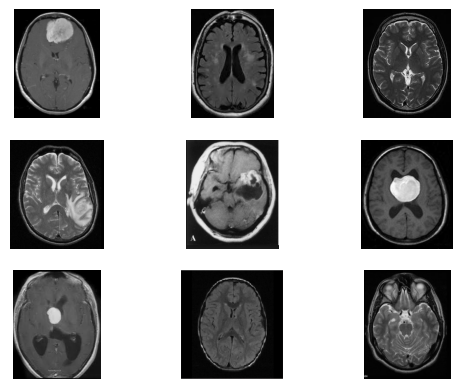

In [66]:
n_col = 3
n_row =3 
plt.figure(figsize=(4,4))
f,axis=plt.subplots(3,3)
for r in range(n_row):
    for c in range(n_col):
        image = Image.open(train_df['image_path'].sample(1).item()).convert('RGB')
        axis[r,c].imshow(image)
        axis[r,c].axis('off')

In [67]:
class MyModule(nn.Module):
    def __init__(self,num_classes=1,freeze=True):
        super().__init__()
        
        self.features = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        
        if freeze:
            for param in self.features.parameters():
                param.requires_grad = False
        num_features = self.features.fc.in_features
        
        self.features.fc = nn.Sequential(
            nn.Linear(num_features,64),
            nn.ReLU(),
            nn.Linear(64,num_classes)
        )
    def forward(self,x):
        return self.features(x)

In [68]:
model = MyModule().to(device)

In [69]:
from torchsummary import summary
summary(model,input_size=(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [70]:
optimizer = torch.optim.Adam(model.parameters(),lr=LR,weight_decay=1e-4)
criterion = nn.BCEWithLogitsLoss()

In [71]:
for x,y in train_dataloader:
    print(x.shape,y.shape)
    break

torch.Size([64, 3, 224, 224]) torch.Size([64])


In [72]:
total_train_loss_plot = []
total_train_acc_plot = []
total_val_loss_plot =[]
total_val_acc_plot = []

best_val_acc = 0
for epoch in range(EPOCH):
    total_train_acc = 0
    total_train_loss = 0
    total_val_acc = 0
    total_val_loss = 0 
    model.train()
    for image,label in tqdm(train_dataloader,desc='Training'):
        image,label = image.to(device),label.to(device).float().unsqueeze(1)
        
        optimizer.zero_grad()
        output = model(image)
        train_loss = criterion(output,label)
        train_loss.backward()
        
        optimizer.step()
        
        total_train_loss+=train_loss.item() * image.size(0)
        preds = torch.sigmoid(output)
        total_train_acc+= (preds.round()==label).sum().item()
        
    total_train_loss_plot.append(round(total_train_loss/len(train_dataset),4))
    total_train_acc_plot.append(round(total_train_acc/len(train_dataset)*100,4))
    
    
    with torch.no_grad():
        model.eval()
        for image,label in val_dataloader:
            image,label = image.to(device),label.to(device).float().unsqueeze(1)
            output = model(image)
            val_loss = criterion(output,label)

            
            total_val_loss += val_loss.item() * image.size(0)
            preds = torch.sigmoid(output)
            total_val_acc += (preds.round()==label).sum().item()
            
    total_val_loss_plot.append(round(total_val_loss/len(val_dataset),4))
    total_val_acc_plot.append(round(total_val_acc/len(val_dataset)*100,4))
        
        
    print(f'Epoch/{epoch} Train Loss : {total_train_loss_plot[epoch]} Train Acc: {total_train_acc_plot[epoch]}%')
    print(f'Epoch/{epoch} Val Loss : {total_val_loss_plot[epoch]} Val Acc: {total_val_acc_plot[epoch]}%')
    
    if total_val_loss/len(val_dataset)> best_val_acc:
        best_val_acc = total_val_loss/len(val_dataset)
        torch.save(model.state_dict(),'best_model_butteryfly.pth')
        print(f'Model saved with val acc:{round(total_val_loss/len(val_dataset)*100,2)}%')

Training: 100%|██████████| 3/3 [00:01<00:00,  1.72it/s]


Epoch/0 Train Loss : 0.6915 Train Acc: 50.8475%
Epoch/0 Val Loss : 0.6372 Val Acc: 63.1579%
Model saved with val acc:63.72%


Training: 100%|██████████| 3/3 [00:01<00:00,  2.62it/s]


Epoch/1 Train Loss : 0.6591 Train Acc: 61.0169%
Epoch/1 Val Loss : 0.6183 Val Acc: 63.1579%


Training: 100%|██████████| 3/3 [00:01<00:00,  2.87it/s]


Epoch/2 Train Loss : 0.6362 Train Acc: 61.0169%
Epoch/2 Val Loss : 0.6078 Val Acc: 65.7895%


Training: 100%|██████████| 3/3 [00:01<00:00,  2.48it/s]


Epoch/3 Train Loss : 0.625 Train Acc: 62.7119%
Epoch/3 Val Loss : 0.6044 Val Acc: 78.9474%


Training: 100%|██████████| 3/3 [00:00<00:00,  3.48it/s]


Epoch/4 Train Loss : 0.6121 Train Acc: 66.6667%
Epoch/4 Val Loss : 0.5996 Val Acc: 78.9474%


Training: 100%|██████████| 3/3 [00:01<00:00,  2.64it/s]


Epoch/5 Train Loss : 0.6105 Train Acc: 69.4915%
Epoch/5 Val Loss : 0.5837 Val Acc: 81.5789%


Training: 100%|██████████| 3/3 [00:00<00:00,  3.00it/s]


Epoch/6 Train Loss : 0.588 Train Acc: 76.8362%
Epoch/6 Val Loss : 0.5635 Val Acc: 76.3158%


Training: 100%|██████████| 3/3 [00:00<00:00,  3.67it/s]


Epoch/7 Train Loss : 0.5957 Train Acc: 70.0565%
Epoch/7 Val Loss : 0.5443 Val Acc: 68.4211%


Training: 100%|██████████| 3/3 [00:00<00:00,  3.87it/s]


Epoch/8 Train Loss : 0.5718 Train Acc: 73.4463%
Epoch/8 Val Loss : 0.528 Val Acc: 71.0526%


Training: 100%|██████████| 3/3 [00:00<00:00,  3.43it/s]


Epoch/9 Train Loss : 0.5598 Train Acc: 70.0565%
Epoch/9 Val Loss : 0.5109 Val Acc: 71.0526%


Training: 100%|██████████| 3/3 [00:00<00:00,  4.00it/s]


Epoch/10 Train Loss : 0.5567 Train Acc: 73.4463%
Epoch/10 Val Loss : 0.4905 Val Acc: 81.5789%


Training: 100%|██████████| 3/3 [00:00<00:00,  3.68it/s]


Epoch/11 Train Loss : 0.5389 Train Acc: 75.1412%
Epoch/11 Val Loss : 0.4747 Val Acc: 84.2105%


Training: 100%|██████████| 3/3 [00:00<00:00,  3.88it/s]


Epoch/12 Train Loss : 0.5181 Train Acc: 76.2712%
Epoch/12 Val Loss : 0.4595 Val Acc: 86.8421%


Training: 100%|██████████| 3/3 [00:00<00:00,  3.57it/s]


Epoch/13 Train Loss : 0.5156 Train Acc: 78.5311%
Epoch/13 Val Loss : 0.4464 Val Acc: 89.4737%


Training: 100%|██████████| 3/3 [00:00<00:00,  3.00it/s]


Epoch/14 Train Loss : 0.5317 Train Acc: 75.7062%
Epoch/14 Val Loss : 0.4341 Val Acc: 89.4737%


Training: 100%|██████████| 3/3 [00:01<00:00,  2.75it/s]


Epoch/15 Train Loss : 0.4772 Train Acc: 77.9661%
Epoch/15 Val Loss : 0.4231 Val Acc: 89.4737%


Training: 100%|██████████| 3/3 [00:00<00:00,  3.89it/s]


Epoch/16 Train Loss : 0.5132 Train Acc: 76.8362%
Epoch/16 Val Loss : 0.4133 Val Acc: 86.8421%


Training: 100%|██████████| 3/3 [00:00<00:00,  3.62it/s]


Epoch/17 Train Loss : 0.4853 Train Acc: 79.661%
Epoch/17 Val Loss : 0.4051 Val Acc: 86.8421%


Training: 100%|██████████| 3/3 [00:00<00:00,  3.22it/s]


Epoch/18 Train Loss : 0.4347 Train Acc: 87.5706%
Epoch/18 Val Loss : 0.3967 Val Acc: 86.8421%


Training: 100%|██████████| 3/3 [00:01<00:00,  2.80it/s]


Epoch/19 Train Loss : 0.4859 Train Acc: 79.661%
Epoch/19 Val Loss : 0.388 Val Acc: 86.8421%


Training: 100%|██████████| 3/3 [00:00<00:00,  3.40it/s]


Epoch/20 Train Loss : 0.42 Train Acc: 84.1808%
Epoch/20 Val Loss : 0.384 Val Acc: 89.4737%


Training: 100%|██████████| 3/3 [00:00<00:00,  3.82it/s]


Epoch/21 Train Loss : 0.4799 Train Acc: 77.9661%
Epoch/21 Val Loss : 0.3798 Val Acc: 89.4737%


Training: 100%|██████████| 3/3 [00:00<00:00,  3.75it/s]


Epoch/22 Train Loss : 0.4613 Train Acc: 83.0508%
Epoch/22 Val Loss : 0.377 Val Acc: 89.4737%


Training: 100%|██████████| 3/3 [00:00<00:00,  3.29it/s]


Epoch/23 Train Loss : 0.4835 Train Acc: 79.096%
Epoch/23 Val Loss : 0.3709 Val Acc: 86.8421%


Training: 100%|██████████| 3/3 [00:01<00:00,  2.12it/s]


Epoch/24 Train Loss : 0.4623 Train Acc: 84.1808%
Epoch/24 Val Loss : 0.3652 Val Acc: 89.4737%


Training: 100%|██████████| 3/3 [00:00<00:00,  3.25it/s]


Epoch/25 Train Loss : 0.4362 Train Acc: 84.7458%
Epoch/25 Val Loss : 0.3563 Val Acc: 89.4737%


Training: 100%|██████████| 3/3 [00:01<00:00,  2.62it/s]


Epoch/26 Train Loss : 0.4407 Train Acc: 81.3559%
Epoch/26 Val Loss : 0.3458 Val Acc: 86.8421%


Training: 100%|██████████| 3/3 [00:00<00:00,  3.54it/s]


Epoch/27 Train Loss : 0.4093 Train Acc: 85.3107%
Epoch/27 Val Loss : 0.344 Val Acc: 89.4737%


Training: 100%|██████████| 3/3 [00:00<00:00,  3.62it/s]


Epoch/28 Train Loss : 0.4171 Train Acc: 82.4859%
Epoch/28 Val Loss : 0.3408 Val Acc: 86.8421%


Training: 100%|██████████| 3/3 [00:00<00:00,  3.19it/s]


Epoch/29 Train Loss : 0.439 Train Acc: 82.4859%
Epoch/29 Val Loss : 0.3422 Val Acc: 84.2105%
